In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

from pandas import read_csv
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

from ucla.core.constants import *
from ucla.core.local_ODE_solver import LocalModel
from ucla.core.physics import SMT

from scipy.interpolate import RegularGridInterpolator


In [2]:
nn_invcc_at_Pbar_TK = lambda Pbar, TK: Pbar*bar_to_AU/(TK*K_to_AU)*AU_to_invcc

T_room_K = 290
Xe_nn_invcc = nn_invcc_at_Pbar_TK(5, T_room_K)
He_nn_invcc = nn_invcc_at_Pbar_TK(74, T_room_K)
Ar_nn_invcc = nn_invcc_at_Pbar_TK(25, T_room_K)

Xe_ionization_energies_eV = np.array([0, 12.1298437, 20.975, 31.05, 42.20 , 54.1, 66.703, 91.6, 105.9778, 179.84, 202.0, 229.02])
Ar_ionization_energies_eV = np.array([0, 15.7596119, 27.62967, 40.735, 59.58, 74.84, 91.290])
He_ionization_energies_eV = np.array([0, 24.587389011, 54.4177655282])

print(f"Xe ne = {Xe_nn_invcc:0.3e} [1/cc] ")
print(f"He ne = {He_nn_invcc:0.3e} [1/cc] ") 
print(f"Ar ne = {Ar_nn_invcc:0.3e} [1/cc] ")

Xe_TK_peak = 16.60952380952381e3 # 0 ns?
He_TK_peak = 14.790528233151186e3 # 0.0031746031746031746 ns
Ar_TK_peak = 17.761029411764707e3 # 0.008097165991902834 ns?

Xe ne = 1.249e+20 [1/cc] 
He ne = 1.848e+21 [1/cc] 
Ar ne = 6.244e+20 [1/cc] 


### Element Information

In [3]:
element='Ar'

if element=='Xe':
    Z, A = 54, 131
    n_i = Xe_nn_invcc *1e6
    m_i = A*m_p
    r_i = 1/(4/3*π*n_i)**(1/3)*m_to_AU
    
    Ti_init = 300 # K
    Te_init = Xe_TK_peak # K

    χ0_eV = 12.1298437  # eV See 
    χ0_J = χ0_eV*eV_to_J

    ionization_file="../../data/Xe5bar_Saha.txt"
    element_data_file = "../../data/experimental_data/Xe_5bar_Te.txt"
    N_n, N_T = 20, 200
    tmax=18e-9
    dt=1e-10
    

elif element=='He':
    Z, A = 2, 4
    n_i = He_nn_invcc *1e6
    m_i = A*m_p
    r_i = 1/(4/3*π*n_i)**(1/3)*m_to_AU

    Ti_init = 300 # K
    Te_init = He_TK_peak # K

    χ0_eV = 24.587389011  # eV See 
    χ0_J = χ0_eV*eV_to_J

    ionization_file="../../data/He74bar_Saha.txt"
    element_data_file = "../../data/experimental_data/He_74bar_Te.txt"

    N_n, N_T = 20, 200
    tmax=1e-9
    dt=1e-11

    
elif element=='Ar':
    Z, A = 18, 39.948
    n_i = Ar_nn_invcc *1e6
    m_i = A*m_p
    r_i = 1/(4/3*π*n_i)**(1/3)*m_to_AU

    Ti_init = 300 # K
    Te_init = Ar_TK_peak # K

    χ0_eV = 15.7596119  # eV See 
    χ0_J = χ0_eV*eV_to_J

    ionization_file="../../data/Ar25bar_Saha.txt"
    element_data_file = "../../data/experimental_data/Ar_25bar_Te.txt"

    N_n, N_T = 20, 200
    tmax=4.5e-9
    dt=1e-11


print(f"Cold pressure: P_cold = {n_i*Ti_init*k_B * Pa_to_AU*AU_to_bar:0.3f} bar = {n_i*Ti_init*k_B * 1e-9:0.3f} GPa ")
print(f"Hot pressure: P_hot = {n_i*Te_init*k_B * Pa_to_AU*AU_to_bar:0.3f} bar = {n_i*Te_init*k_B * 1e-9:0.3f} GPa ")
print(f"Density: ρ = {n_i*m_i:0.3f} [kg/m^3] =  {1e-3*n_i*m_i:0.3f} [g/cm^3] ")
print(f"Ion sphere radius: r_i = {r_i:0.3f} [au]")


Cold pressure: P_cold = 25.862 bar = 0.003 GPa 
Hot pressure: P_hot = 1531.124 bar = 0.153 GPa 
Density: ρ = 41.655 [kg/m^3] =  0.042 [g/cm^3] 
Ion sphere radius: r_i = 13.716 [au]


In [4]:


def make_ionization_function(Z, n_i, Zbar_rescale = 1, χ_rescale = 1):
    """
    Gets the ionization profile of the ion using TF AA fit.
    Args:
        None
    Returns:
        None
    """

    saved_data = read_csv(ionization_file, delim_whitespace=True, header=1)
    n_invm3_mesh = np.array(saved_data['n[1/cc]']).reshape(N_n, N_T)*1e6
    T_K_mesh     = np.array(saved_data['T[K]']).reshape(N_n, N_T)
    Zbar_mesh    = np.array(saved_data['Zbar']).reshape(N_n, N_T)
    χ_J_mesh    = np.array(saved_data['χ_1[eV]']).reshape(N_n, N_T)*eV_to_J
    Δχ_J_mesh    = χ0_J - χ_J_mesh
    
    zbar_interp = RegularGridInterpolator((n_invm3_mesh[:,0],T_K_mesh[0,:]), Zbar_mesh, bounds_error=False)
    Δχ_interp   = RegularGridInterpolator((n_invm3_mesh[:,0],T_K_mesh[0,:]), Δχ_J_mesh, bounds_error=False)
        
    @np.vectorize()
    def Zbar_func(Te): # in kelvin
        # above_n_i = n_i > np.max(n_invm3_mesh[:,0])
        # below_n_i = n_i < np.min(n_invm3_mesh[:,0])
        above_Te  = Te > np.max(T_K_mesh[0,:])
        below_Te  = Te < np.min(T_K_mesh[0,:])

        if above_Te:
            return 1.0
        elif below_Te:
            return np.min(Zbar_mesh)
        else:
            return Zbar_rescale * zbar_interp((n_i,Te))

    @np.vectorize()
    def χ_func(Te):
        # above_n_i = n_i > np.max(n_invm3_mesh[:,0])
        # below_n_i = n_i < np.min(n_invm3_mesh[:,0])
        above_Te  = Te > np.max(T_K_mesh[0,:])
        below_Te  = Te < np.min(T_K_mesh[0,:])

        if above_Te:
            n_i_closest = np.argmin( np.abs( n_invm3_mesh[:,0]-n_i ))
            return Δχ_J_mesh[n_i_closest,-1]
        elif below_Te:
            n_i_closest = np.argmin( np.abs( n_invm3_mesh[:,0]-n_i ))
            return Δχ_J_mesh[n_i_closest,0]
        return χ_rescale * (χ0_J - Δχ_interp((n_i,Te)))

    return Zbar_func, χ_func
Zbar_func = make_ionization_function(Z, n_i)[0]

In [5]:
Zbar = 1#Zbar_func(Ar_TK_peak)
n_e  = n_i * Zbar
x_1  = Zbar
Te   = Ar_TK_peak
Ti   = 300
Z1   = 1

In [6]:
R = 40e-6/2 # Using initial FWHM~40 μm
Area = 4*π*R**2
Vol  = 4/3*π*R**3
Ee_init = 1.5*n_e*k_B*Te*Vol

# G electron-ion equilibration energy loss
dEdt_G = SMT.ei_coupling_factor(n_e, n_i*x_1, m_i, Z1, Te, Ti) *(Te-Ti)*Vol # G: [kB/m^3/s]  -> J/s
dTdt_G = dEdt_G * Te/Ee_init *1e-3*1e-9
τ_G = (Ee_init/dEdt_G)*1e9

# σ_radiation energy loss
ε = 1 # emissivity
dEdt_γ = ε*σ_SB*Area* (Te)**4 # J/s
dTdt_γ = dEdt_γ * Te/Ee_init *1e-3*1e-9
τ_γ = (Ee_init/dEdt_γ)*1e9

# Thermal Conduction
dTdr = (Te-Ti)/R
dEdt_κi = SMT.ion_thermal_conductivity(n_e, n_i*x_1, m_i, Z1, Te, Ti) * dTdr * Area  # J/s
dEdt_κe = SMT.electron_thermal_conductivity(n_e, n_i*x_1, m_i, Z1, Te, Ti) * dTdr * Area  # J/s
dEdt_κ = dEdt_κe + dEdt_κi
dTdt_κ = dEdt_κ * Te/Ee_init *1e-3*1e-9
τ_κ = (Ee_init/dEdt_κ)*1e9

# Work
γ = 5/3
c_sound = np.sqrt(γ*k_B*Te/m_i)
dRdt = c_sound
dVdt = 4*π*R**2*dRdt
P = n_e*k_B*Te
dEdt_PdV = P*dVdt #  J/S
dTdt_PdV = dEdt_PdV * Te/Ee_init *1e-3*1e-9
τ_PdV    = (Ee_init/dEdt_PdV)*1e9 

# Adiabatic work
# T(t) = T_0 (R_0/R(t))^{4/3} -> dTdt = T(t) * -4/3 * dRdt/R
dEdt_PdV_adiabatic = Ee_init*4/3 * dRdt/R
dTdt_PdV_adiabatic = dEdt_PdV_adiabatic * Te/Ee_init *1e-3*1e-9
τ_PdV_adiabatic = (Ee_init/dEdt_PdV_adiabatic)*1e9 



In [7]:
print(f"Electron-ion Equilibration  : dE/dt = {dEdt_G:0.3e} [J/s], dT/dt = {dTdt_G:6.3f} [kK/ns], τ_G = {τ_G:0.3f} [ns] ")
print(f"Thermal Conduction          : dE/dt = {dEdt_κ:0.3e} [J/s], dT/dt = {dTdt_κ:6.3f} [kK/ns], τ_κ = {τ_κ:0.3f} [ns] ")
print(f"Radiation Loss              : dE/dt = {dEdt_γ:0.3e} [J/s], dT/dt = {dTdt_γ:6.3f} [kK/ns], τ_γ = {τ_γ:0.3e} [ns] ")
print(f"Work ('max' possible)       : dE/dt = {dEdt_PdV:0.3e} [J/s], dT/dt = {dTdt_PdV:6.3f} [kK/ns], τ_PdV = {τ_PdV:0.3e} [ns] ")
# print(f"Adiabatic (Mora) Work       : dE/dt = {dEdt_PdV_adiabatic:0.3e} [J/s], dT/dt = {dTdt_PdV_adiabatic:6.3f} [kK/ns], τ_PdV = {τ_PdV_adiabatic:0.3e} [ns] ")

Electron-ion Equilibration  : dE/dt = 3.474e+04 [J/s], dT/dt = 80.168 [kK/ns], τ_G = 0.222 [ns] 
Thermal Conduction          : dE/dt = 1.963e+02 [J/s], dT/dt =  0.453 [kK/ns], τ_κ = 39.212 [ns] 
Radiation Loss              : dE/dt = 2.836e+01 [J/s], dT/dt =  0.065 [kK/ns], τ_γ = 2.713e+02 [ns] 
Work ('max' possible)       : dE/dt = 1.905e+03 [J/s], dT/dt =  4.396 [kK/ns], τ_PdV = 4.040e+00 [ns] 


\item large $\chi_{IPD}$ 
\item $\Gamma_{ii} \gg 1$ (early) to $\Gamma_{ii} \sim 1$ (late)
\item $D_{Ar}/\ell^{MFP}_{photon} > 3$


# Expansion/Contraction

In [8]:
from scipy.optimize import curve_fit
from pandas import read_csv

In [9]:
Ar_FWHM_data = read_csv("../../data/experimental_data/Ar_25bar_FWHM.txt", header=1, delim_whitespace=True)

def MM_func(t_ns, A_1, A_2, τ_1, τ_2):
    return A_1*np.exp(-t_ns/τ_1) + A_2*np.exp(-t_ns/τ_2)


In [10]:
p0 = [6, 34, 0.2, 200]
MM_fit = curve_fit(MM_func, Ar_FWHM_data['t[ns]'], Ar_FWHM_data['FWHM[μm]'], p0=p0)
MM_fit

(array([6.05781946e+00, 3.38579839e+01, 2.14864917e-01, 2.41235317e+02]),
 array([[ 3.22171730e-02, -6.29221518e-03, -7.31254295e-04,
          3.68435321e+00],
        [-6.29221518e-03,  1.02289307e-02, -9.35962298e-04,
         -5.78428415e+00],
        [-7.31254295e-04, -9.35962298e-04,  2.18777283e-04,
          5.09718821e-01],
        [ 3.68435321e+00, -5.78428415e+00,  5.09718821e-01,
          3.78782267e+03]]))

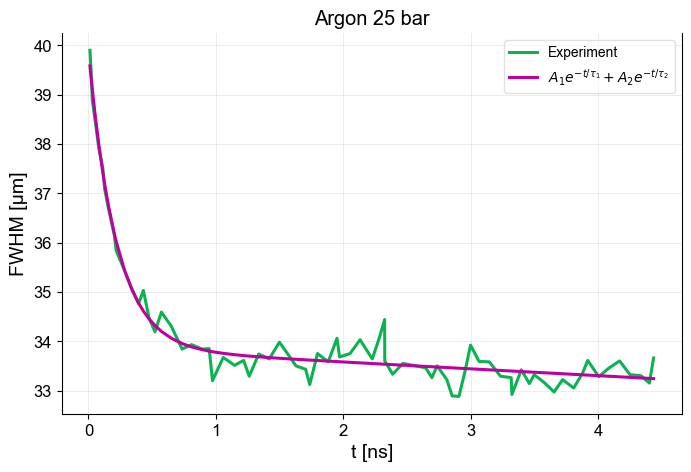

In [11]:
fig, ax = plt.subplots()

R_fit_data = MM_func(Ar_FWHM_data['t[ns]'], *MM_fit[0])

ax.plot(Ar_FWHM_data['t[ns]'], Ar_FWHM_data['FWHM[μm]'], label='Experiment')
ax.plot(Ar_FWHM_data['t[ns]'], R_fit_data, label=r"$A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2}$")

ax.set_xlabel("t [ns]")
ax.set_ylabel("FWHM [μm]")

ax.set_title("Argon 25 bar")
ax.legend()
# ax.set_xscale('log')

In [12]:
Ar_Te_data = read_csv("../../data/experimental_data/Ar_25bar_Te.txt", header=1, delim_whitespace=True)

In [13]:
MM_Mora_T_fit = Ar_Te_data['T[kK]'][0] * (R_fit_data[0]/R_fit_data)**(4/3)

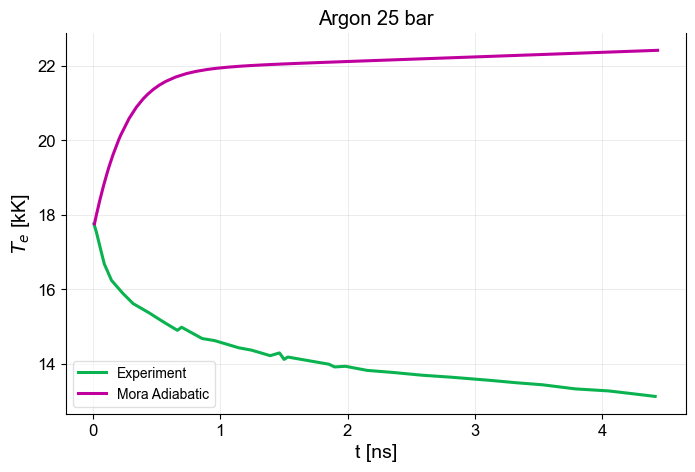

In [14]:
fig, ax = plt.subplots()

ax.plot(Ar_Te_data['t[ns]'], Ar_Te_data['T[kK]'], label="Experiment")
ax.plot(Ar_FWHM_data['t[ns]'], MM_Mora_T_fit, label="Mora Adiabatic")
# ax.plot(Ar_Te_data['t[ns]'], MM_func(Ar_FWHM_data['t[ns]'], *MM_fit[0]))

ax.set_xlabel("t [ns]")
ax.set_ylabel(r"$T_e$ [kK]")

ax.set_title("Argon 25 bar")
ax.legend()